In [303]:
# utilities
import argparse
import os
import random
import time
import math
import socket

# data
import numpy as np
import pandas as pd

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# machine learning
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [305]:
myHostName = socket.gethostname()
print(myHostName)

Tarins-MacBook


In [306]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

### Dataloader

In [307]:
class GWDataset(Dataset):
    def __init__(self, x, y):
        # convert to numpy array
        self.original_parameters = y
        self.parameters = self.original_parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1]))

        x = np.transpose(x)
        self.original_data = x
        self.data = self.original_data
        self.augmented_data = np.empty(shape = (self.data.shape[0], 0))

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(10, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            # signal_2 = self.data[:, idx_2]
            # signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.window_warping_augmentation(signal_1)
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just sample parameters for now, haven't figured out a way to augment them to make consistent with signal augmentation
            augmented_parameter = self.parameters[idx_1, :]
            augmented_parameter = augmented_parameter.reshape(1, -1)

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print(self.data.shape)
        print(self.parameters.shape)

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # pad signals with edge values to be length 512
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized, parameter

In [308]:
x = pd.read_csv("../data/gw-raw-data/richers_1764.csv")
y = pd.read_csv("../data/gw-raw-data/richers_1764_parameters.csv")

# remove erroneous signals and select only beta_IC_b as label
keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
y = y.iloc[keep_signals_idx,:]
# select continuous beta_IC_b values for now
y = y[['beta1_IC_b']].astype('float32')
# bin labels to get discretised data
# y['beta1_IC_b_bins'] = pd.qcut(y['beta1_IC_b'], q=10, labels=False)
# y = y[['beta1_IC_b_bins']].astype('float32')
# convert to numpy array
y = y.values

# drop corresponding signals which have erroneous parameter values
x = x.iloc[:,keep_signals_idx]
x = x.values.astype('float32')

# only transpore x due to compatibility issues with train_test_split
x = np.transpose(x)

# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=manualSeed)

train_data = GWDataset(x_train, y_train)
test_data = GWDataset(x_test, y_test)

# split the total augmentated signal count to 6000 to match distribution of GAN training dataset
train_data.augmentation(4800)
test_data.augmentation(1200)

train_data.calc_stats()
test_data.calc_stats()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(407, 4800)
(4800, 1)
(407, 1200)
(1200, 1)
Dataset mean:  -0.23525746
Dataset std:  31.68961
Dataset scaling factor (to match noise in generator):  5
Dataset mean:  -0.3557647
Dataset std:  32.39233
Dataset scaling factor (to match noise in generator):  5


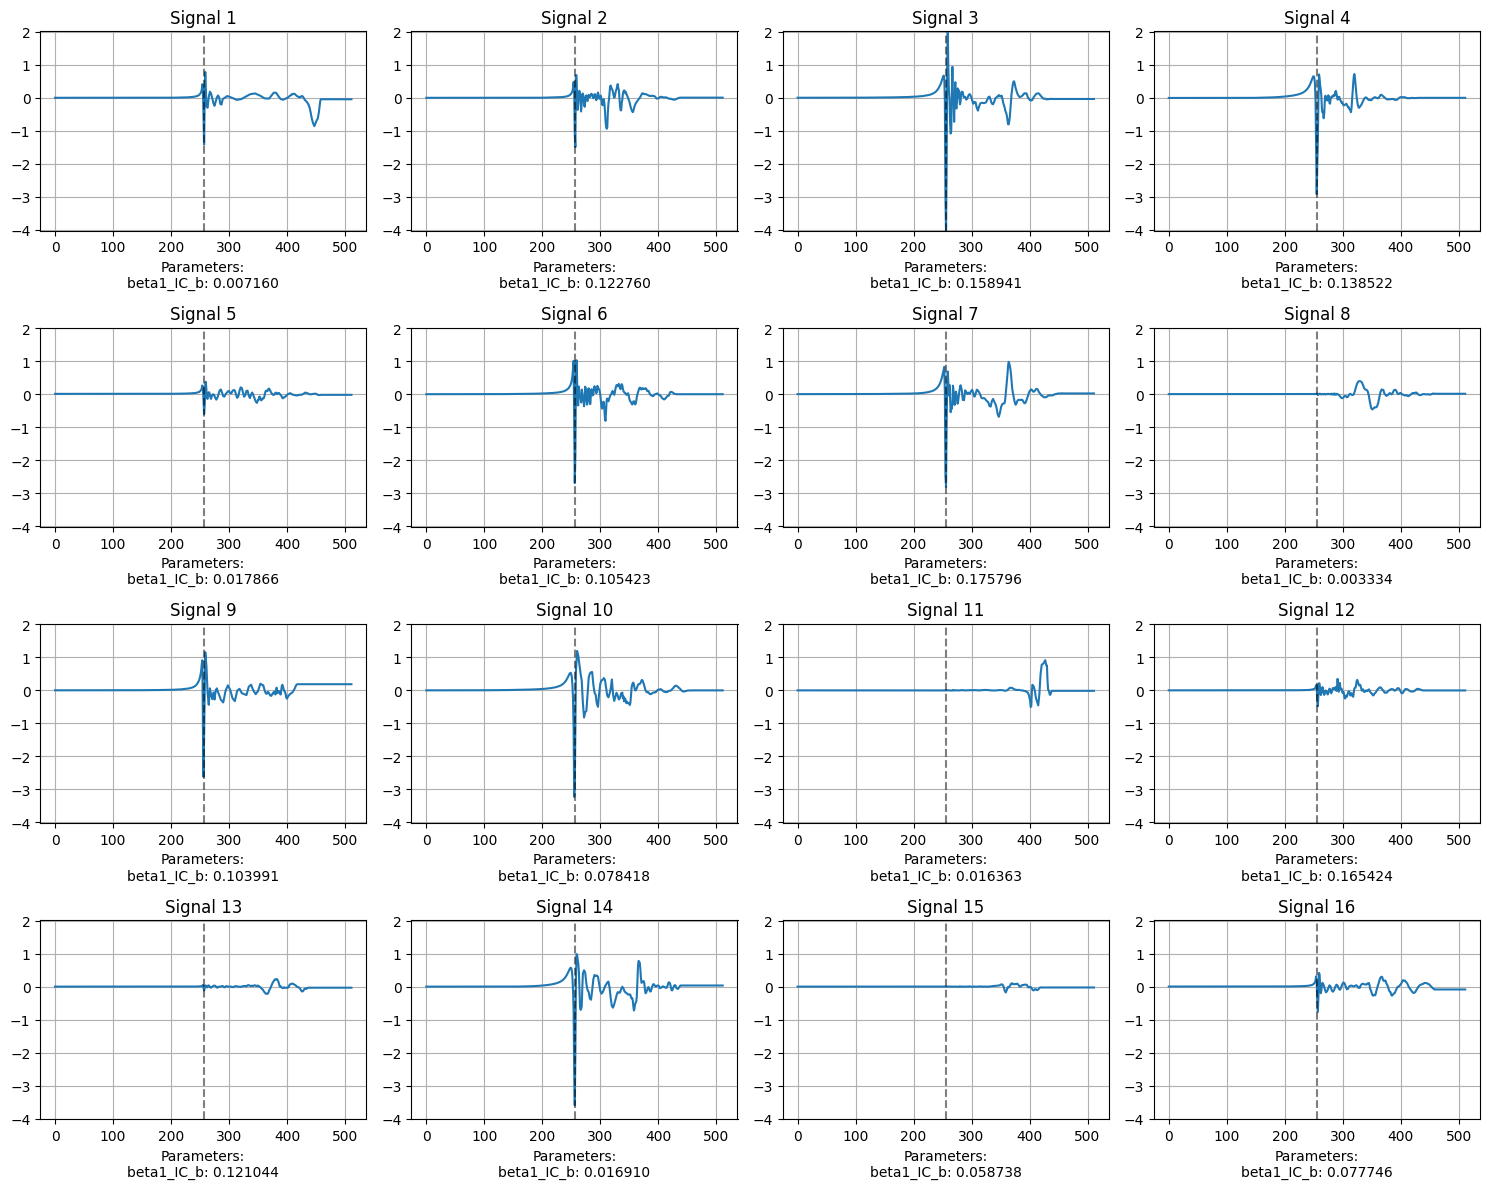

In [309]:
real_signals_batch, real_parameter_batch  = next(iter(train_loader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b']

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}'
        ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

### Weight Initialisation

In [310]:
# custom weights initialization called on classifier
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Classifier Network

In [311]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
        #     x = self.fc(x)
            return x

In [312]:
net = Discriminator().to(device)
net.apply(weights_init)

print(net)

model = Discriminator()
summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout2d(p=0.2,

/Users/tarineccleston/Documents/software-ds/gravitational-waves/gw-env/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


### Loss functions and Optimisers

In [313]:
criterion = nn.L1Loss()
# maybe we need to use Adam
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [314]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # print(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # if (i % 10 == 0):
            # print(outputs)
        # print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
    running_loss = 0.0

print('Finished Training')

/Users/tarineccleston/Documents/software-ds/gravitational-waves/gw-env/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 16384])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[1,   150] loss: 49.434
[2,   150] loss: 41.914


KeyboardInterrupt: 

In [ ]:
PATH = './beta_net.pth'
torch.save(net.state_dict(), PATH)

### Testing

In [ ]:
dataiter = iter(test_loader)
data, labels = next(dataiter)

print(labels)

tensor([[[0.1057]],

        [[0.0489]],

        [[0.0091]],

        [[0.1607]],

        [[0.0098]],

        [[0.0955]],

        [[0.0088]],

        [[0.2027]],

        [[0.2142]],

        [[0.0892]],

        [[0.0056]],

        [[0.1139]],

        [[0.0699]],

        [[0.1423]],

        [[0.0916]],

        [[0.0651]],

        [[0.1023]],

        [[0.0011]],

        [[0.0221]],

        [[0.0004]],

        [[0.0043]],

        [[0.0090]],

        [[0.1128]],

        [[0.1682]],

        [[0.1175]],

        [[0.1478]],

        [[0.0377]],

        [[0.1260]],

        [[0.2008]],

        [[0.1652]],

        [[0.0994]],

        [[0.0865]]])


In [ ]:
net = Discriminator()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(data)
print(outputs)

tensor([[ 3.6363e-01],
        [-1.6052e-01],
        [ 1.3917e-01],
        [ 1.8887e-01],
        [ 1.5317e-01],
        [-6.4272e-02],
        [ 2.3691e-01],
        [ 2.8353e+00],
        [ 4.6752e+00],
        [-1.5200e-03],
        [ 1.3408e-01],
        [ 2.0715e-01],
        [ 3.5033e-01],
        [-1.5086e-01],
        [ 1.8421e-01],
        [ 3.2941e-01],
        [ 3.6152e-02],
        [-1.2134e-02],
        [ 3.8112e-03],
        [ 8.7788e-02],
        [ 1.9323e-01],
        [ 2.4253e-01],
        [ 2.3393e-01],
        [ 1.1936e-01],
        [ 4.9952e-02],
        [ 1.2283e-01],
        [ 2.1826e-01],
        [ 2.9500e-01],
        [ 1.2201e-01],
        [ 8.6775e-02],
        [ 3.3613e-01],
        [ 9.0746e-02]], grad_fn=<ViewBackward0>)
